# Random Forest Training

In [37]:
"""
By feeding the trading signals (as our features) and the binary daily return (positive or negative, as the target) in a RFM, we will get  a model that predicts whether there will be a positive return or not.  And that should be our trading signal.  
As we get live data it will be sent through the trained RFM which will then return a prediction for tomorrow's return (assuming daily data).  The prediction would determine if we go long or short for the day.  
Really good example in the class repo:  class/15-Algorithmic-Trading/3/Activities/02-Ins_Random_Forest_Trading 

"""

"\nBy feeding the trading signals (as our features) and the binary daily return (positive or negative, as the target) in a RFM, we will get  a model that predicts whether there will be a positive return or not.  And that should be our trading signal.  \nAs we get live data it will be sent through the trained RFM which will then return a prediction for tomorrow's return (assuming daily data).  The prediction would determine if we go long or short for the day.  \nReally good example in the class repo:  class/15-Algorithmic-Trading/3/Activities/02-Ins_Random_Forest_Trading \n\n"

---

### Import Libraries and Dependencies

In [46]:
# Initial imports
import pandas as pd
import numpy as np 
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
%matplotlib inline
#import hvplot.pandas

# Needed for decision tree visualization
#import pydotplus
#from IPython.display import Image

import warnings
warnings.filterwarnings('ignore')

In [47]:
import sys
import os

module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from libs.signals import signals
from libs.data.kraken_data import kraken_data

### Import data from signal, prices, sentiment into DataFrames  

In [48]:
# get signals from libs (in this version BTC)
trading_signals_df  = pd.DataFrame()
trading_signals_df = signals.technical_indicator_signal('btc')
trading_signals_df.drop(['close','signal'], axis=1, inplace=True)

trading_signals_df.reset_index(inplace=True)
trading_signals_df['Date'] = pd.to_datetime(trading_signals_df['Date']).dt.date
trading_signals_df.set_index('Date', inplace=True)

trading_signals_df.head()

,volume,ewma_x,macd,bollinger,rsi,psar,volume_ewma_x
Date,,,,,,,
2019-01-20,1547.136188,-1,-1.0,1,NaN,1,-1
2019-01-21,1985.344973,1,1.0,1,-1.0,-1,1
2019-01-22,2110.964339,1,1.0,1,-1.0,1,1
2019-01-23,1735.043844,1,1.0,1,0.0,1,1
2019-01-24,1149.972270,1,1.0,1,0.0,1,-1


In [56]:
trading_signals_df.drop('volume', axis=1, inplace=True)

In [57]:
trading_signals_df.head()

,ewma_x,macd,bollinger,rsi,psar,volume_ewma_x
Date,,,,,,
2019-01-20,-1,-1.0,1,NaN,1,-1
2019-01-21,1,1.0,1,-1.0,-1,1
2019-01-22,1,1.0,1,-1.0,1,1
2019-01-23,1,1.0,1,0.0,1,1
2019-01-24,1,1.0,1,0.0,1,-1


In [58]:
# Import cryto sentiment signals (csv)
#Date,Ticker,Compound,Positive,Negative,Neutral,Sentiment Signal

#what_columns=['Date', 'Open_XXBTZ', 'High_XXBTZ', 'Low_XXBTZ', 'Close_XXBTZ', 'Vol_XXBTZ']
sentiment_path = Path("../data/BitcoinSentimentSignals.csv")
#crypto_price = pd.read_csv(cryptos_path, usecols=what_columns, parse_dates=True, infer_datetime_format=True, delimiter=',')
crypto_sentiment = pd.read_csv(sentiment_path, parse_dates=True, infer_datetime_format=True, delimiter=',')
crypto_sentiment['Date'] = pd.to_datetime(crypto_sentiment.Date, infer_datetime_format=True)
crypto_sentiment.set_index('Date', inplace=True)

# Rename columns 
crypto_sentiment.rename(columns={'Sentiment Signal':'Sentiment_Signal'}, inplace=True)

crypto_sentiment.drop('Ticker', axis=1, inplace=True)
#crypto_price.drop(btc_df.index[0], inplace=True)         #delete 1st row nan 

crypto_sentiment = crypto_sentiment.loc[::-1]               #reverse rows order

crypto_sentiment.head()

,Compound,Positive,Negative,Neutral,Sentiment_Signal
Date,,,,,
2019-01-01,0.4003,0.071,0.0,0.929,1
2019-01-02,0.0000,0.000,0.0,1.000,0
2019-01-03,0.6393,0.185,0.0,0.815,1
2019-01-04,0.0000,0.000,0.0,0.000,0
2019-01-05,0.0000,0.000,0.0,0.000,0


In [59]:
# Import cryto prices (in this version BTC)
  
what_columns=['Date', 'Open_XXBTZ', 'High_XXBTZ', 'Low_XXBTZ', 'Close_XXBTZ', 'Vol_XXBTZ']
cryptos_path = Path("../data/crypto_pricesx.csv")
crypto_price = pd.read_csv(cryptos_path, usecols=what_columns, parse_dates=True, infer_datetime_format=True, delimiter=',')
crypto_price['Date'] = pd.to_datetime(crypto_price.Date, infer_datetime_format=True)
crypto_price['Date'] = pd.to_datetime(crypto_price['Date']).dt.date
crypto_price.set_index('Date', inplace=True)

# Rename columns 
crypto_price.rename(columns={'Open_XXBTZ':'open', 'High_XXBTZ':'high', 'Low_XXBTZ':'low', 'Close_XXBTZ':'close', 'Vol_XXBTZ': 'volume'}, inplace=True)

# Compute daily_return
crypto_price['daily_return'] = (crypto_price[['close']].pct_change(fill_method='ffill'))
crypto_price['daily_return'] = crypto_price['daily_return'].replace(-np.inf, np.nan).dropna()
#crypto_price.drop('close', axis=1, inplace=True)

# Compute daily change in volume 
crypto_price['vol_change'] = (crypto_price[['volume']].pct_change())
crypto_price['vol_change'] = crypto_price['vol_change'].replace(-np.inf, np.nan).dropna()
#crypto_price.drop('volume', axis=1, inplace=True)

#crypto_price.drop(btc_df.index[0], inplace=True)         #delete 1st row nan 

crypto_price.head()

,open,high,low,close,volume,daily_return,vol_change
Date,,,,,,,
2019-01-20,3534.8,3565.0,3488.0,3533.4,1547.136188,NaN,NaN
2019-01-21,3531.7,3607.5,3440.0,3575.8,1985.344973,0.012000,0.283239
2019-01-22,3575.7,3613.2,3524.2,3556.1,2110.964339,-0.005509,0.063273
2019-01-23,3556.1,3591.0,3531.3,3568.3,1735.043844,0.003431,-0.178080
2019-01-24,3571.2,3576.6,3511.6,3560.0,1149.972270,-0.002326,-0.337209


In [60]:

print(f'trading_signals_df -> {trading_signals_df.shape}')
print(f'crypto_price -> {crypto_price.shape}')
print(f'crypto_sentiment -> {crypto_sentiment.shape}')

trading_signals_df -> (720, 6)
crypto_price -> (720, 7)
crypto_sentiment -> (745, 5)


In [61]:
# Merge signal and prices in a single dataframe (we will integrate sentiment analysis as well as the third source of features)
trading_signals_df = trading_signals_df.join(crypto_price, how="inner")
trading_signals_df = trading_signals_df.join(crypto_sentiment, how="inner")

In [62]:
print(f'trading_signals_df -> {trading_signals_df.shape}')

trading_signals_df -> (720, 18)


In [63]:
trading_signals_df.head()

,ewma_x,macd,bollinger,rsi,psar,volume_ewma_x,open,high,low,close,volume,daily_return,vol_change,Compound,Positive,Negative,Neutral,Sentiment_Signal
Date,,,,,,,,,,,,,,,,,,
2019-01-20,-1,-1.0,1,NaN,1,-1,3534.8,3565.0,3488.0,3533.4,1547.136188,NaN,NaN,0.8442,0.185,0.0,0.815,1
2019-01-21,1,1.0,1,-1.0,-1,1,3531.7,3607.5,3440.0,3575.8,1985.344973,0.012000,0.283239,0.3400,0.055,0.0,0.945,1
2019-01-22,1,1.0,1,-1.0,1,1,3575.7,3613.2,3524.2,3556.1,2110.964339,-0.005509,0.063273,0.0000,0.000,0.0,0.000,0
2019-01-23,1,1.0,1,0.0,1,1,3556.1,3591.0,3531.3,3568.3,1735.043844,0.003431,-0.178080,0.0000,0.000,0.0,0.000,0
2019-01-24,1,1.0,1,0.0,1,-1,3571.2,3576.6,3511.6,3560.0,1149.972270,-0.002326,-0.337209,0.0000,0.000,0.0,0.000,0


In [64]:
# Construct the dependent variable y where if daily return is greater than 0, then 1, else, 0.

trading_signals_df['positive_return'] = np.where(trading_signals_df['daily_return'] > 0, 1.0, 0.0)
trading_signals_df['positive_volume'] = np.where(trading_signals_df['vol_change'] > 0, 1.0, 0.0)
trading_signals_df.head()

,ewma_x,macd,bollinger,rsi,psar,volume_ewma_x,open,high,low,close,volume,daily_return,vol_change,Compound,Positive,Negative,Neutral,Sentiment_Signal,positive_return,positive_volume
Date,,,,,,,,,,,,,,,,,,,,
2019-01-20,-1,-1.0,1,NaN,1,-1,3534.8,3565.0,3488.0,3533.4,1547.136188,NaN,NaN,0.8442,0.185,0.0,0.815,1,0.0,0.0
2019-01-21,1,1.0,1,-1.0,-1,1,3531.7,3607.5,3440.0,3575.8,1985.344973,0.012000,0.283239,0.3400,0.055,0.0,0.945,1,1.0,1.0
2019-01-22,1,1.0,1,-1.0,1,1,3575.7,3613.2,3524.2,3556.1,2110.964339,-0.005509,0.063273,0.0000,0.000,0.0,0.000,0,0.0,1.0
2019-01-23,1,1.0,1,0.0,1,1,3556.1,3591.0,3531.3,3568.3,1735.043844,0.003431,-0.178080,0.0000,0.000,0.0,0.000,0,1.0,0.0
2019-01-24,1,1.0,1,0.0,1,-1,3571.2,3576.6,3511.6,3560.0,1149.972270,-0.002326,-0.337209,0.0000,0.000,0.0,0.000,0,0.0,0.0


### Set X-Variable List and Filter to Obtain Associated Values

In [65]:
# Set X variable list of features
x_var_list = ['ewma_x', 'macd', 'bollinger', 'rsi', 'psar', 'positive_volume', 'Sentiment_Signal']

# Filter by x-variable list
trading_signals_df[x_var_list].tail()

,ewma_x,macd,bollinger,rsi,psar,positive_volume,Sentiment_Signal
Date,,,,,,,
2021-01-04,1,1.0,-1,-1.0,-1,0.0,1
2021-01-05,1,1.0,-1,-1.0,1,1.0,-1
2021-01-06,1,1.0,-1,-1.0,1,1.0,1
2021-01-07,1,1.0,-1,-1.0,1,0.0,0
2021-01-08,1,1.0,-1,-1.0,1,0.0,1


### Shift the DataFrame Index by 1

In [66]:
# Shift DataFrame values by 1
trading_signals_df[x_var_list] = trading_signals_df[x_var_list].shift(1)
trading_signals_df[x_var_list].tail()

,ewma_x,macd,bollinger,rsi,psar,positive_volume,Sentiment_Signal
Date,,,,,,,
2021-01-04,1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0
2021-01-05,1.0,1.0,-1.0,-1.0,-1.0,0.0,1.0
2021-01-06,1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0
2021-01-07,1.0,1.0,-1.0,-1.0,1.0,1.0,1.0
2021-01-08,1.0,1.0,-1.0,-1.0,1.0,0.0,0.0


### Drop NAs and Replace Infs (Positive/Negative Infinity) 

In [67]:
# Drop NAs and replace positive/negative infinity values
trading_signals_df.dropna(subset=x_var_list, inplace=True)
trading_signals_df.dropna(subset=['daily_return', 'vol_change'], inplace=True)
trading_signals_df = trading_signals_df.replace([np.inf, -np.inf], np.nan)
trading_signals_df.head()

,ewma_x,macd,bollinger,rsi,psar,volume_ewma_x,open,high,low,close,volume,daily_return,vol_change,Compound,Positive,Negative,Neutral,Sentiment_Signal,positive_return,positive_volume
Date,,,,,,,,,,,,,,,,,,,,
2019-01-22,1.0,1.0,1.0,-1.0,-1.0,1,3575.7,3613.2,3524.2,3556.1,2110.964339,-0.005509,0.063273,0.0000,0.000,0.000,0.000,1.0,0.0,1.0
2019-01-23,1.0,1.0,1.0,-1.0,1.0,1,3556.1,3591.0,3531.3,3568.3,1735.043844,0.003431,-0.178080,0.0000,0.000,0.000,0.000,0.0,1.0,1.0
2019-01-24,1.0,1.0,1.0,0.0,1.0,-1,3571.2,3576.6,3511.6,3560.0,1149.972270,-0.002326,-0.337209,0.0000,0.000,0.000,0.000,0.0,0.0,0.0
2019-01-25,1.0,1.0,1.0,0.0,1.0,-1,3560.0,3673.0,3535.6,3556.2,1443.406965,-0.001067,0.255167,0.7269,0.295,0.000,0.705,0.0,0.0,0.0
2019-01-26,1.0,0.0,1.0,0.0,1.0,-1,3555.8,3562.2,3470.8,3531.3,1170.105705,-0.007002,-0.189345,-0.5994,0.000,0.085,0.915,1.0,0.0,1.0


In [68]:
trading_signals_df.shape

(715, 20)

### Assign Training and Testing Windows

In [69]:
# Construct training start and end dates
training_start = trading_signals_df.index.min().strftime(format= '%Y-%m-%d')
training_end = '2020-06-30'

# Construct testing start and end dates
testing_start =  '2020-07-01'
testing_end = trading_signals_df.index.max().strftime(format= '%Y-%m-%d')

# Print training and testing start/end dates
print(f"Training Start: {training_start}")
print(f"Training End: {training_end}")
print(f"Testing Start: {testing_start}")
print(f"Testing End: {testing_end}")

Training Start: 2019-01-22
Training End: 2020-06-30
Testing Start: 2020-07-01
Testing End: 2021-01-08


### Separate X and y Training Datasets

In [70]:
# Construct the X_train and y_train datasets
X_train = trading_signals_df[x_var_list][training_start:training_end]
y_train = trading_signals_df['positive_return'][training_start:training_end]

X_train.tail()

,ewma_x,macd,bollinger,rsi,psar,positive_volume,Sentiment_Signal
Date,,,,,,,
2020-06-26,-1.0,-1.0,1.0,0.0,-1.0,0.0,-1.0
2020-06-27,-1.0,-1.0,1.0,0.0,-1.0,0.0,1.0
2020-06-28,-1.0,-1.0,1.0,0.0,-1.0,0.0,1.0
2020-06-29,-1.0,-1.0,1.0,0.0,-1.0,1.0,0.0
2020-06-30,-1.0,-1.0,1.0,0.0,-1.0,0.0,-1.0


In [71]:
y_train.tail()

Date
2020-06-26    0.0
2020-06-27    1.0
2020-06-28    1.0
2020-06-29    0.0
2020-06-30    1.0
Name: positive_return, dtype: float64

### Separate X and y Testing Datasets

In [72]:
# Separate X test and y test datasets
X_test = trading_signals_df[x_var_list][testing_start:testing_end]
y_test = trading_signals_df['positive_return'][testing_start:testing_end]

X_test.tail()

,ewma_x,macd,bollinger,rsi,psar,positive_volume,Sentiment_Signal
Date,,,,,,,
2021-01-04,1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0
2021-01-05,1.0,1.0,-1.0,-1.0,-1.0,0.0,1.0
2021-01-06,1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0
2021-01-07,1.0,1.0,-1.0,-1.0,1.0,1.0,1.0
2021-01-08,1.0,1.0,-1.0,-1.0,1.0,0.0,0.0


In [73]:
y_test.tail()

Date
2021-01-04    1.0
2021-01-05    1.0
2021-01-06    1.0
2021-01-07    1.0
2021-01-08    0.0
Name: positive_return, dtype: float64

In [74]:
# Creating StandardScaler instance
scaler = StandardScaler()

# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)

# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

### Import SKLearn Library and Classes

In [75]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

### Train Random Forest Model 

In [76]:
# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
# The parameters for the RandomTress seems to be very weak, only 100 trees and 3 levels
# Might it be better n_estimators=2000, max_depth=10

model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0)
model.fit(X_train_scaled, y_train)

# Make a prediction of "y" values from the X_test dataset
predictions = model.predict(X_test_scaled)

# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()                             #Column positive return 
Results["predicted_value"] = predictions                #prediction 
Results

,positive_return,predicted_value
Date,,
2020-07-01,0.0,1.0
2020-07-02,0.0,0.0
2020-07-03,1.0,0.0
2020-07-04,0.0,0.0
2020-07-05,1.0,0.0
2020-07-06,0.0,0.0
2020-07-07,1.0,0.0
2020-07-08,0.0,1.0
2020-07-09,1.0,1.0


In [27]:
## Evaluate the model
### at this stage we should evaluate the model, how good does it perform??
### predicission, recall, confussion matrix, r2 squares ....
### this is an iteractive process until we get the right evaluation out of the model 

## Model Evaluation

In [77]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)


In [78]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,20,52
Actual 1,20,97


Accuracy Score : 0.6190476190476191
Classification Report
              precision    recall  f1-score   support

         0.0       0.50      0.28      0.36        72
         1.0       0.65      0.83      0.73       117

    accuracy                           0.62       189
   macro avg       0.58      0.55      0.54       189
weighted avg       0.59      0.62      0.59       189



In [79]:

# Calculate the absolute errors
errors = abs(predictions - y_test)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')


Mean Absolute Error: 0.38 degrees.


### Save Pre-Trained Model Using Joblib

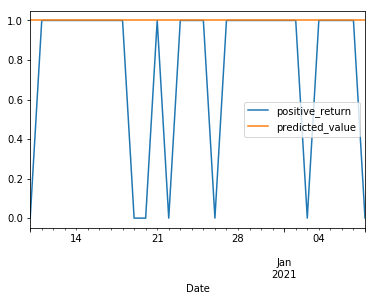

In [80]:
# Plot last 10 records of predicted vs. actual results
#Results[['positive_return', 'Predicted Value']].plot(figsize=(20,10))
Results[['positive_return', 'predicted_value']].tail(30).plot()


### Replace Predicted Values 0 as -1 (For Shorting)

In [81]:
Results['predicted_value'].replace(0, -1, inplace=True)
Results

,positive_return,predicted_value
Date,,
2020-07-01,0.0,1.0
2020-07-02,0.0,-1.0
2020-07-03,1.0,-1.0
2020-07-04,0.0,-1.0
2020-07-05,1.0,-1.0
2020-07-06,0.0,-1.0
2020-07-07,1.0,-1.0
2020-07-08,0.0,1.0
2020-07-09,1.0,1.0


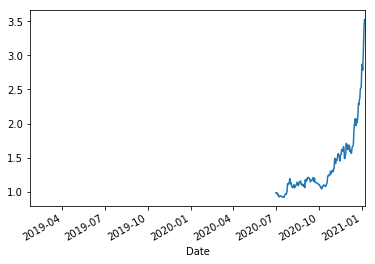

In [82]:
# Calculate cumulative return of model and plot the result
(1 + (trading_signals_df['daily_return'] * Results['predicted_value'])).cumprod().plot()



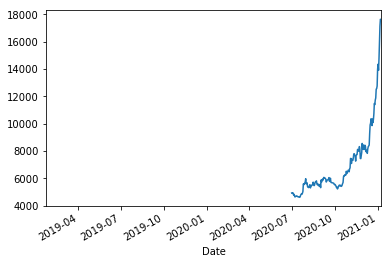

In [83]:
# Set initial capital allocation
initial_capital = 5000

# Plot cumulative return of model in terms of capital
cumulative_return_capital = initial_capital * (1 + (trading_signals_df['daily_return'] * Results['predicted_value'])).cumprod()
cumulative_return_capital.plot()

In [84]:
# Save the pre-trained model
from joblib import dump, load
dump(model, 'random_forest_model.joblib')

['random_forest_model.joblib']

## Features Weight 

In [85]:
# Random Forests in sklearn will automatically calculate feature importance
importances = model.feature_importances_

In [86]:
# Sort the features by their importance
sorted(zip(model.feature_importances_, X_test.columns), reverse=True)

[(0.23656586517196504, 'Sentiment_Signal'),
 (0.1753475668696659, 'ewma_x'),
 (0.16034139495499405, 'macd'),
 (0.14022970146346955, 'positive_volume'),
 (0.11422021291852764, 'rsi'),
 (0.08964277237976195, 'psar'),
 (0.08365248624161603, 'bollinger')]

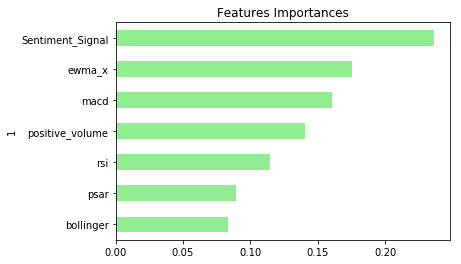

In [87]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(model.feature_importances_, X_test.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)

In [88]:
importances_sorted

,Feature Importances
1,
bollinger,0.083652
psar,0.089643
rsi,0.114220
positive_volume,0.140230
macd,0.160341
ewma_x,0.175348
Sentiment_Signal,0.236566


In [4]:
import hvplot.pandas
importances_sorted.hvplot(kind='bar', title='Feature Relative Importance Scores', invert=True, ylabel='Feature Realtive Importance Score', xlabel='Feature')


NameError: name 'importances_sorted' is not defined

In [ ]:
imp_matrix = pd.DataFrame({
    'ewma_x': imp_list[0],
    'macd': imp_list[1],
    'bollinger': imp_list[2],
    'rsi': imp_list[3],
    'psar': imp_list[4],
    'volume_ewma_x': imp_list[5]
}, index=[1])

imp_matrix.sort_values(by=[1], axis=1, ascending=False).hvplot(kind='bar', title='Feature Relative Importance Scores', invert=True, ylabel='Feature Realtive Importance Score', xlabel='Feature')

In [89]:
rfm_signals = pd.DataFrame({
        'close': trading_signals_df['close'][testing_start:testing_end],
        'actual_return': trading_signals_df['daily_return'][testing_start:testing_end], 
        'binary_return': Results.positive_return,
        'predicted_value': Results.predicted_value,
    })

rfm_signals.head(25)
    #return rfm_signals

,close,actual_return,binary_return,predicted_value
Date,,,,
2020-07-01,9086.0,-0.016081,0.0,1.0
2020-07-02,9058.0,-0.003082,0.0,-1.0
2020-07-03,9138.5,0.008887,1.0,-1.0
2020-07-04,9083.8,-0.005986,0.0,-1.0
2020-07-05,9348.2,0.029107,1.0,-1.0
2020-07-06,9256.8,-0.009777,0.0,-1.0
2020-07-07,9440.1,0.019802,1.0,-1.0
2020-07-08,9240.2,-0.021176,0.0,1.0
2020-07-09,9286.0,0.004957,1.0,1.0
